
# LightGBM model


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

## 1. Load Data

In [ ]:
# Load the data
train_df = pd.read_csv('train_df.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test_data = pd.read_csv('test_df.csv', low_memory=False)
val_data = pd.read_csv('val_df.csv', low_memory=False)

## 2. Data Preparation for LightGBM Model

In [13]:
# Combine patient and time into patient_time and rename to ID
train_df['ID'] = train_df['patient'].astype(str) + '_' + train_df['time'].astype(str)
val_data['ID'] = val_data['patient'].astype(str) + '_' + val_data['time'].astype(str)
test_data['ID'] = test_data['patient'].astype(str) + '_' + test_data['time'].astype(str)

# Drop the original patient and time columns
train_df = train_df.drop(columns=['patient', 'time', 'Unit1', 'Unit2'])
val_data = val_data.drop(columns=['patient', 'time', 'Unit1', 'Unit2'])
test_data = test_data.drop(columns=['patient', 'time', 'Unit1', 'Unit2'])

# Define features and target
features = [col for col in train_df.columns if col not in ['SepsisLabel', 'ID']]
target = 'SepsisLabel'

# Apply Min-Max scaling
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
val_data[features] = scaler.transform(val_data[features])
test_data[features] = scaler.transform(test_data[features])

X_train = train_df.drop(columns = ['SepsisLabel', 'ID'])
y_train = train_df[target]

X_valid = val_data.drop(columns = ['SepsisLabel', 'ID'])
y_valid = val_data[target]


In [21]:
X_valid.shape

(163643, 36)

## 3. Training the Model

In [32]:

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
val_data_lgb = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# Define parameters for the LightGBM model
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': ['binary_logloss', 'auc'],
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9
}
train_logloss = []
val_logloss = []
def log_callback(env):
    if env.iteration % 50 == 0:  
        train_logloss.append(env.evaluation_result_list[0][2])  
        val_logloss.append(env.evaluation_result_list[2][2]) 
        
# Train the model with log_evaluation callback
bst = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data_lgb],
    callbacks=[ lgb.log_evaluation(50), log_callback]
)



[LightGBM] [Info] Number of positive: 297764, number of negative: 901834
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8820
[LightGBM] [Info] Number of data points in the train set: 1199598, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.248220 -> initscore=-1.108129
[LightGBM] [Info] Start training from score -1.108129
[50]	training's binary_logloss: 0.460177	training's auc: 0.872269	valid_1's binary_logloss: 0.265813	valid_1's auc: 0.774922
[100]	training's binary_logloss: 0.409984	training's auc: 0.889882	valid_1's binary_logloss: 0.243173	valid_1's auc: 0.783791
[150]	training's binary_logloss: 0.368613	training's auc: 0.917094	valid_1's binary_logloss: 0.225959	valid_1's auc: 0.78633
[200]	training's binary_logloss: 0.326859	training's auc: 0.939161	valid_1's binary_logloss: 0.208999	valid_1's auc: 0.786422


In [91]:
val_logloss

[0.5571421284333307,
 0.45886921667242403,
 0.4091042979819197,
 0.367587283651147,
 0.3255291477606696,
 0.27555067039771886,
 0.24853743895372374,
 0.22976258000453811,
 0.21551569340297377,
 0.20349737363649348,
 0.1925727790258368,
 0.18273242966504588,
 0.17487612672081873,
 0.16639744277943383,
 0.15946018354290722,
 0.15310253855015588,
 0.1468698591878558,
 0.14098306420711448,
 0.13652079786469065,
 0.13239855237173548]

## 4. Convergence

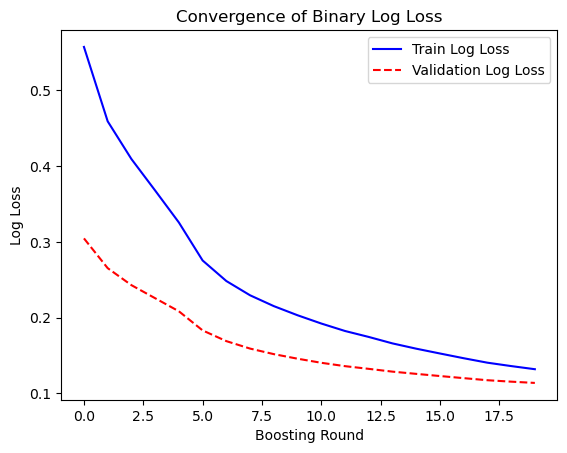

In [33]:


plt.plot(train_logloss, label='Train Log Loss', color='blue')
plt.plot(val_logloss, label='Validation Log Loss', color='red', linestyle='--')
plt.title('Convergence of Binary Log Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

## 5. Predictions

In [34]:

valid_features = [col for col in val_data.columns if col not in ['ID']]
predictions_val = bst.predict(X_valid)
y_pred_valid = (predictions_val > .5 ).astype("int32")


if len(predictions_val) != len(val_data):
    raise ValueError(f"Length of predictions ({len(predictions)}) does not match length of test data ({len(val_data)})")


valid_pred = pd.DataFrame({
    'ID': val_data['ID'],
    'SepsisLabel' : y_pred_valid,
    'probability': predictions_val
})

valid_pred

,ID,SepsisLabel,probability
0,11627_1,0,0.047027
1,11627_2,0,0.012828
2,11627_3,0,0.013151
3,11627_4,0,0.015092
4,11627_5,0,0.009628
...,...,...,...
163638,11255_37,0,0.011828
163639,11255_38,0,0.014991
163640,11255_39,0,0.008443
163641,11255_40,0,0.013033


In [35]:
# Evaluate
cf = confusion_matrix(y_valid, valid_pred['SepsisLabel'] )
rc  = recall_score(y_valid, valid_pred['SepsisLabel'] )
pc = precision_score(y_valid, valid_pred['SepsisLabel'] )
f1 = f1_score(y_valid, valid_pred['SepsisLabel']  )
ac = accuracy_score(y_valid, valid_pred['SepsisLabel']  )

print('accuracy_score', ac)
print('confusion matrix', cf)
print('recall', rc)
print('precision', pc)
print(f"F1 Score: {f1}")

accuracy_score 0.9732221970997843
confusion matrix [[158948   1691]
 [  2691    313]]
recall 0.10419440745672437
precision 0.156187624750499
F1 Score: 0.125


## 6. Performance Optimization

In [36]:
def performance_metrics(Y, Y_hat, threshold = .5):

    ## Classifying for different thresholds

    Y_hat = (Y_hat >= threshold).astype(int)

    # Making sure that each value is 0 or 1
    Y = np.squeeze(Y)
    Y_pred = np.squeeze(Y_hat)

    # Counting for each part of the matrix
    t_pos = np.sum((Y == 1) & (Y_hat == 1))  # True Positives
    t_neg = np.sum((Y == 0) & (Y_hat == 0))  # True Negatives
    f_pos = np.sum((Y == 0) & (Y_hat == 1))  # False Positives
    f_neg = np.sum((Y == 1) & (Y_hat == 0))  # False Negatives


    # Precsion, Recall, and False Positive Rate
    precision = t_pos/(t_pos + f_pos) 
    recall = t_pos/(t_pos+f_neg) if (t_pos + f_pos) > 0 else 0
    f_pos_rate = f_pos/(f_pos+t_neg)
    t_pos_rate = t_pos/(t_pos+f_neg)

    return  precision, recall, f_pos_rate, t_pos_rate

In [37]:
def threshold_predictions(valid_y, pred_val_y):

  thresholds = np.arange(0.0, 1.01, 0.01)


  precisions_valid = []
  recalls_valid= []
  false_positives_rates_valid =[]
  true_positives_rates_valid = []


  ## Computing the metrics for each threshold
  for threshold in thresholds:
          precision_val, recall_val, f_p_val,t_p_val = performance_metrics(valid_y, pred_val_y['probability'], threshold)
          precisions_valid.append(precision_val)
          recalls_valid.append(recall_val)
          false_positives_rates_valid.append(f_p_val)
          true_positives_rates_valid.append(t_p_val)

  return thresholds, precisions_valid, recalls_valid, false_positives_rates_valid, true_positives_rates_valid

In [38]:
thresholds, precisions_valid, recalls_valid, false_positives_rates_valid, true_positives_rates_valid = threshold_predictions(y_valid, valid_pred)

C:\Users\mbdav\AppData\Local\Temp\ipykernel_31980\3463268109.py:19: RuntimeWarning: invalid value encountered in scalar divide
  precision = t_pos/(t_pos + f_pos)
C:\Users\mbdav\AppData\Local\Temp\ipykernel_31980\3463268109.py:19: RuntimeWarning: invalid value encountered in scalar divide
  precision = t_pos/(t_pos + f_pos)
C:\Users\mbdav\AppData\Local\Temp\ipykernel_31980\3463268109.py:19: RuntimeWarning: invalid value encountered in scalar divide
  precision = t_pos/(t_pos + f_pos)
C:\Users\mbdav\AppData\Local\Temp\ipykernel_31980\3463268109.py:19: RuntimeWarning: invalid value encountered in scalar divide
  precision = t_pos/(t_pos + f_pos)
C:\Users\mbdav\AppData\Local\Temp\ipykernel_31980\3463268109.py:19: RuntimeWarning: invalid value encountered in scalar divide
  precision = t_pos/(t_pos + f_pos)
C:\Users\mbdav\AppData\Local\Temp\ipykernel_31980\3463268109.py:19: RuntimeWarning: invalid value encountered in scalar divide
  precision = t_pos/(t_pos + f_pos)
C:\Users\mbdav\AppData

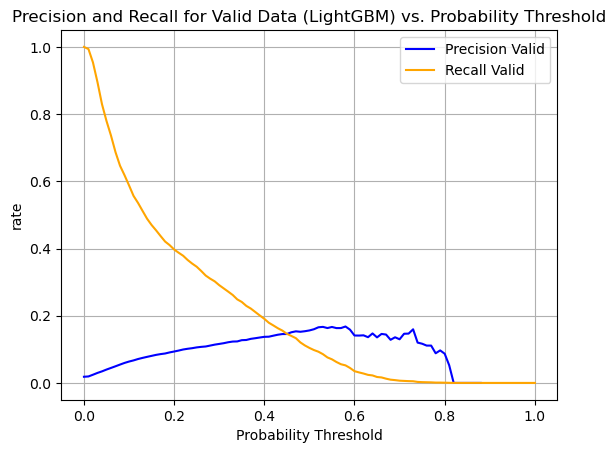

In [39]:

# Plot test Precision, Recall, and false positives
plt.plot(thresholds, precisions_valid, label='Precision Valid', color='blue')
plt.plot(thresholds, recalls_valid, label='Recall Valid', color='orange')


plt.xlabel('Probability Threshold')
plt.ylabel('rate')
plt.title('Precision and Recall for Valid Data (LightGBM) vs. Probability Threshold')
plt.legend()
plt.grid()
plt.show()

In [40]:
precision_recall_diffs_valid = np.abs(np.array(precisions_valid) - np.array(recalls_valid))
sorted_indices_valid = np.argsort(precision_recall_diffs_valid)


print("Thresholds and corresponding precision-recall differences:")
for i, idx in enumerate(sorted_indices_valid[7:12]):
    print(f"Threshold: {thresholds[idx]}, Precision: {precisions_valid[idx]}, Recall: {recalls_valid[idx]}, Diff: {precision_recall_diffs_valid[idx]}")

min_diff_index_valid = sorted_indices_valid[7]
closest_threshold_valid = thresholds[min_diff_index_valid]

print('best threshold (valid):', closest_threshold_valid)

Thresholds and corresponding precision-recall differences:
Threshold: 0.45, Precision: 0.14555702917771884, Recall: 0.14613848202396804, Diff: 0.0005814528462491919
Threshold: 0.44, Precision: 0.1454319453076445, Recall: 0.15579227696404793, Diff: 0.010360331656403432
Threshold: 0.46, Precision: 0.1507537688442211, Recall: 0.13981358189081225, Diff: 0.010940186953408843
Threshold: 0.43, Precision: 0.14344382516867116, Recall: 0.16278295605858856, Diff: 0.0193391308899174
Threshold: 0.47000000000000003, Precision: 0.15355086372360843, Recall: 0.13315579227696406, Diff: 0.020395071446644375
best threshold (valid): 0.45


## 7. Performance on .4 Threshold

In [41]:
y_pred_valid = (predictions_val > .4).astype("int32")


if len(predictions_val) != len(val_data):
    raise ValueError(f"Length of predictions ({len(predictions)}) does not match length of test data ({len(val_data)})")


valid_pred = pd.DataFrame({
    'ID': val_data['ID'],
    'SepsisLabel' : y_pred_valid,
    'probability': predictions_val
})

In [42]:
# Evaluate
cf = confusion_matrix(y_valid, valid_pred['SepsisLabel'] )
rc  = recall_score(y_valid, valid_pred['SepsisLabel'] )
pc = precision_score(y_valid, valid_pred['SepsisLabel'] )
f1 = f1_score(y_valid, valid_pred['SepsisLabel']  )
ac = accuracy_score(y_valid, valid_pred['SepsisLabel']  )

print('accuracy_score', ac)
print('confusion matrix', cf)
print('recall', rc)
print('precision', pc)
print(f"F1 Score: {f1}")

accuracy_score 0.9631209400952072
confusion matrix [[157035   3604]
 [  2431    573]]
recall 0.190745672436751
precision 0.13717979411060569
F1 Score: 0.15958780114190224


## 8. Feature Importance

In [45]:

feature_importances_split = bst.feature_importance(importance_type='split')


feature_importances_gain = bst.feature_importance(importance_type='gain')

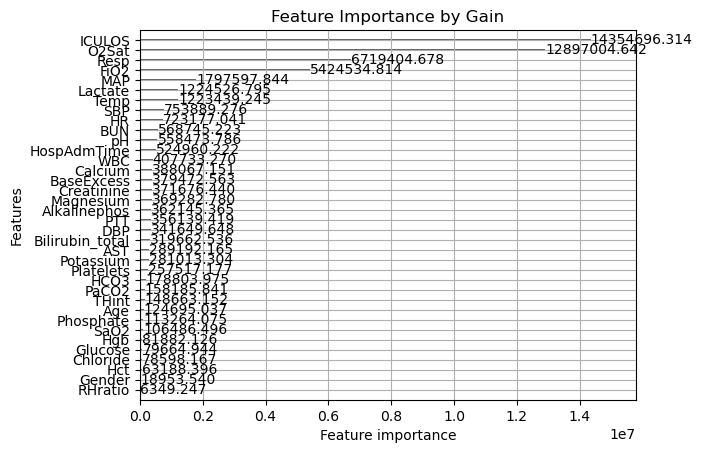

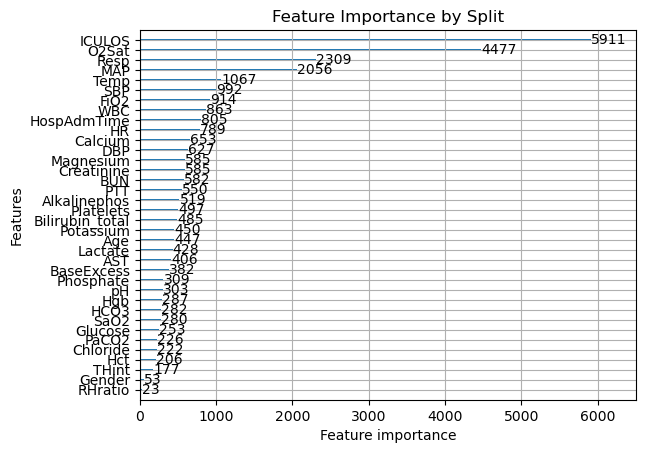

In [47]:
lgb.plot_importance(bst, importance_type='gain')
plt.title("Feature Importance by Gain")
plt.show()


lgb.plot_importance(bst, importance_type='split')
plt.title("Feature Importance by Split")
plt.show()

## 9. ROC Curve

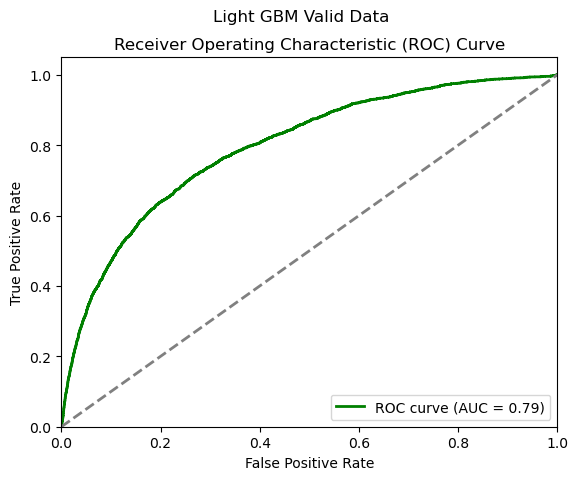

In [43]:
## Gradient Boosting Valid ROC curve

fpr, tpr, thresholds = roc_curve(y_valid, valid_pred['probability'])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.suptitle('Light GBM Valid Data')
plt.legend(loc="lower right")
plt.show()

## Test Predictions and Submission Files

In [ ]:

test_features = [col for col in test_data.columns if col not in ['ID']]
predictions = bst.predict(test_data[test_features])


if len(predictions) != len(test_data):
    raise ValueError(f"Length of predictions ({len(predictions)}) does not match length of test data ({len(test_data)})")


submission = pd.DataFrame({
    'ID': test_data['ID'],
    'SepsisLabel': predictions
})
submission.to_csv('lightGBM_submission.csv', index=False)

In [10]:

test_features = [col for col in test_data.columns if col not in ['ID']]
predictions = bst.predict(test_data[test_features])


if len(predictions) != len(test_data):
    raise ValueError(f"Length of predictions ({len(predictions)}) does not match length of test data ({len(test_data)})")


submission = pd.DataFrame({
    'ID': test_data['ID'],
    'SepsisLabel': predictions
})
submission.to_csv('lightGBM_submission.csv', index=False)